In [1]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time, end_time = "05/12/2021 00:00", "05/12/2021 01:00"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

print(f'reading CSV files')
start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in tqdm(glob.glob(path + "*.csv")):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        df_tmp = df_tmp[df_tmp["sens_pos"]== "C1.1.1"]
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

#df = df[df['sens_pos'].isin(self.sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
data = df[df["sens_pos"]== "C1.1.1"]
data["zN"] = data["z"]-np.mean(data["z"])

reading CSV files


100%|██████████| 1450/1450 [00:25<00:00, 56.75it/s]


In [3]:
data["vars"] = data["zN"].rolling(window=10).var().fillna(0)

(0.0, 2e-06)

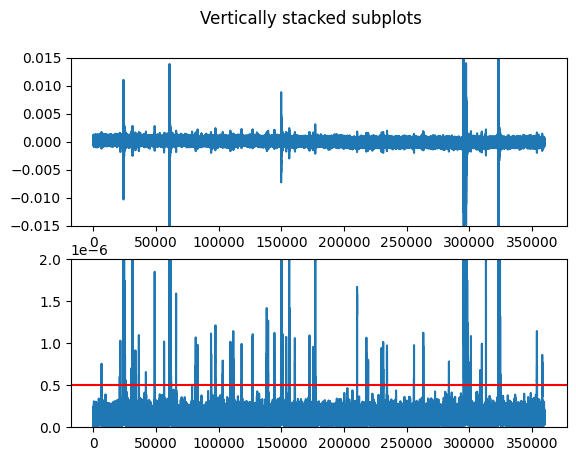

In [4]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(data["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(data["vars"])
axs[1].axhline(y=5e-7, color='r')
axs[1].set_ylim(0, 2e-6)

In [5]:
threshold = 5e-7
data["outlier"] = data.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
data

,sens_pos,z,ts,zN,vars,outlier
0,C1.1.1,-0.988022,2021-12-05 00:00:00.311,0.000514,0.000000e+00,False
1,C1.1.1,-0.988098,2021-12-05 00:00:00.321,0.000438,0.000000e+00,False
2,C1.1.1,-0.988403,2021-12-05 00:00:00.331,0.000133,0.000000e+00,False
3,C1.1.1,-0.987945,2021-12-05 00:00:00.341,0.000591,0.000000e+00,False
4,C1.1.1,-0.988479,2021-12-05 00:00:00.351,0.000057,0.000000e+00,False
...,...,...,...,...,...,...
359955,C1.1.1,-0.988403,2021-12-05 01:00:00.033,0.000133,7.172696e-08,False
359956,C1.1.1,-0.988632,2021-12-05 01:00:00.043,-0.000096,2.722908e-08,False
359957,C1.1.1,-0.988708,2021-12-05 01:00:00.053,-0.000172,2.742311e-08,False
359958,C1.1.1,-0.988556,2021-12-05 01:00:00.063,-0.000020,2.748779e-08,False


In [6]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf = pesaDataDf[["Id", "StartTimeStr", "ClassId", "GrossWeight", "Velocity", "VelocityUnit"]]
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["StartTimeStr"])
pesaDataDf["Time"] = pesaDataDf["Time"].dt.strftime('%Y-%d-%m %H:%M:00')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]) + pd.to_timedelta(-1,'H')
pesaDataDf["EstimatedTime"] = pesaDataDf["Time"] + pd.to_timedelta(600/(pesaDataDf["Velocity"]/3.6),'S')
pesaDataDf["MaxTime"] = pesaDataDf["EstimatedTime"] + pd.to_timedelta(60,'S')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
pesaDataDf.sort_values(by="Id", inplace=True)
pesaDataDf.reset_index(drop=True, inplace=True)
labelsDf = pesaDataDf[(pesaDataDf["Time"]>="2021-12-05 00:00:00") & (pesaDataDf["Time"]<="2021-12-05 01:00:00")]
labelsDf.shape

(24, 9)

In [7]:
aggDf = labelsDf.groupby(["Time"])["Id"].count()
totMinDf = aggDf.reset_index()
totMinDf["Time"] = pd.to_datetime(totMinDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
totMinDf.rename(columns={"Id": "Vehicles"}, inplace=True)
oneByMinDf = totMinDf[totMinDf["Vehicles"] == 1]
oneByMinDf = oneByMinDf["Time"].tolist()
oneByMinDf

['2021-12-05 00:05:00',
 '2021-12-05 00:06:00',
 '2021-12-05 00:07:00',
 '2021-12-05 00:10:00',
 '2021-12-05 00:13:00',
 '2021-12-05 00:22:00',
 '2021-12-05 00:24:00',
 '2021-12-05 00:25:00',
 '2021-12-05 00:29:00',
 '2021-12-05 00:34:00',
 '2021-12-05 00:46:00',
 '2021-12-05 00:48:00',
 '2021-12-05 00:53:00']

In [8]:
testLabelsDf = labelsDf[labelsDf["Time"].isin(oneByMinDf)]
testLabelsDf

,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime
6444,52376,05/12/2021 01:05,Classe 1,1325,80,Km/h,2021-12-05 00:05:00,2021-12-05 00:05:27.000000000,2021-12-05 00:06:27.000000000
6445,52377,05/12/2021 01:06,Classe 1,1270,95,Km/h,2021-12-05 00:06:00,2021-12-05 00:06:22.736842105,2021-12-05 00:07:22.736842105
6446,52378,05/12/2021 01:07,Classe 1,2100,77,Km/h,2021-12-05 00:07:00,2021-12-05 00:07:28.051948052,2021-12-05 00:08:28.051948052
6449,52381,05/12/2021 01:10,Classe 1,1530,87,Km/h,2021-12-05 00:10:00,2021-12-05 00:10:24.827586207,2021-12-05 00:11:24.827586207
6450,52382,05/12/2021 01:13,Classe 1,1385,106,Km/h,2021-12-05 00:13:00,2021-12-05 00:13:20.377358491,2021-12-05 00:14:20.377358491
6451,52383,05/12/2021 01:22,Classe 2,2165,98,Km/h,2021-12-05 00:22:00,2021-12-05 00:22:22.040816327,2021-12-05 00:23:22.040816327
6452,52384,05/12/2021 01:24,Classe 9,21965,73,Km/h,2021-12-05 00:24:00,2021-12-05 00:24:29.589041096,2021-12-05 00:25:29.589041096
6453,52385,05/12/2021 01:25,Classe 1,1640,89,Km/h,2021-12-05 00:25:00,2021-12-05 00:25:24.269662921,2021-12-05 00:26:24.269662921
6454,52386,05/12/2021 01:29,Classe 1,1555,122,Km/h,2021-12-05 00:29:00,2021-12-05 00:29:17.704918033,2021-12-05 00:30:17.704918033
6455,52387,05/12/2021 01:34,Classe 1,1820,118,Km/h,2021-12-05 00:34:00,2021-12-05 00:34:18.305084746,2021-12-05 00:35:18.305084746


In [16]:
threshold = 5e-7
def labelGenerator(row):
    slice = data[(data["ts"]>= row["EstimatedTime"]) & (data["ts"]<= row["MaxTime"])].copy(deep=True)
    slice["outlier"] = slice.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
    outliers = slice[slice["outlier"] == True].reset_index().to_dict("records")

    last = 0
    timeStart = outliers[0]["ts"]
    flag = True
    group = []
    maxPower = 0
    label = np.nan
    for outlier in outliers:
        if ((outlier["index"] - last) < 100) or flag:
            group.append(outlier["index"])
            flag = False
            timeEnd = outlier["ts"]
        else:
            start, end = group[0], group[-1]
            signalPower = np.sqrt(np.mean(np.array(data["zN"].iloc[start:end])**2))**2 
            if signalPower >= maxPower:
                maxPower = signalPower
                label = {"start": start, "end": end, "signalPower": signalPower}
            group = [outlier["index"],]
        last = outlier["index"]

    start, end = group[0], group[-1]
    signalPower = np.sqrt(np.mean(np.array(data["zN"].iloc[start:end])**2))**2 
    if signalPower >= maxPower:
        maxPower = signalPower
        label = {"start": start, "end": end, "signalPower": signalPower}

    return label

In [19]:
testLabelsDf["label"] = testLabelsDf.apply(labelGenerator, axis=1)

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
testLabelsDf

,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime,label
6444,52376,05/12/2021 01:05,Classe 1,1325,80,Km/h,2021-12-05 00:05:00,2021-12-05 00:05:27.000000000,2021-12-05 00:06:27.000000000,"{'start': 33559, 'end': 33570, 'signalPower': ..."
6445,52377,05/12/2021 01:06,Classe 1,1270,95,Km/h,2021-12-05 00:06:00,2021-12-05 00:06:22.736842105,2021-12-05 00:07:22.736842105,"{'start': 41900, 'end': 41930, 'signalPower': ..."
6446,52378,05/12/2021 01:07,Classe 1,2100,77,Km/h,2021-12-05 00:07:00,2021-12-05 00:07:28.051948052,2021-12-05 00:08:28.051948052,"{'start': 48873, 'end': 48932, 'signalPower': ..."
6449,52381,05/12/2021 01:10,Classe 1,1530,87,Km/h,2021-12-05 00:10:00,2021-12-05 00:10:24.827586207,2021-12-05 00:11:24.827586207,"{'start': 65988, 'end': 66045, 'signalPower': ..."
6450,52382,05/12/2021 01:13,Classe 1,1385,106,Km/h,2021-12-05 00:13:00,2021-12-05 00:13:20.377358491,2021-12-05 00:14:20.377358491,"{'start': 83144, 'end': 83186, 'signalPower': ..."
6451,52383,05/12/2021 01:22,Classe 2,2165,98,Km/h,2021-12-05 00:22:00,2021-12-05 00:22:22.040816327,2021-12-05 00:23:22.040816327,"{'start': 139412, 'end': 139539, 'signalPower'..."
6452,52384,05/12/2021 01:24,Classe 9,21965,73,Km/h,2021-12-05 00:24:00,2021-12-05 00:24:29.589041096,2021-12-05 00:25:29.589041096,"{'start': 149805, 'end': 150770, 'signalPower'..."
6453,52385,05/12/2021 01:25,Classe 1,1640,89,Km/h,2021-12-05 00:25:00,2021-12-05 00:25:24.269662921,2021-12-05 00:26:24.269662921,"{'start': 156300, 'end': 156429, 'signalPower'..."
6454,52386,05/12/2021 01:29,Classe 1,1555,122,Km/h,2021-12-05 00:29:00,2021-12-05 00:29:17.704918033,2021-12-05 00:30:17.704918033,"{'start': 177107, 'end': 177209, 'signalPower'..."
6455,52387,05/12/2021 01:34,Classe 1,1820,118,Km/h,2021-12-05 00:34:00,2021-12-05 00:34:18.305084746,2021-12-05 00:35:18.305084746,"{'start': 210485, 'end': 210532, 'signalPower'..."


In [40]:
threshold = 5e-7
def groupsGenerator(minTime, maxTime):
    slice = data[(data["ts"]>= minTime) & (data["ts"]<= maxTime)].copy(deep=True)
    slice["outlier"] = slice.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
    outliers = slice[slice["outlier"] == True].reset_index().to_dict("records")

    last = minTime
    timeStart = outliers[0]["ts"]
    flag = True
    groups = []
    group = []
    label = np.nan
    for outlier in outliers:
        if ((outlier["ts"] - last).total_seconds() < 1) or flag:
            group.append(outlier["ts"])
            flag = False
            timeEnd = outlier["ts"]
        else:
            start, end = min(group), max(group)
            groupSignal = data[(data["ts"]>= start) & (data["ts"]<= end)]["zN"]
            signalPower = np.sqrt(np.mean(np.array(groupSignal)**2))**2 
            label = {"start": start, "end": end, "signalPower": signalPower}
            groups.append(label)
            group = [outlier["ts"],]
        last = outlier["ts"]

    start, end = min(group), max(group)
    groupSignal = data[(data["ts"]>= start) & (data["ts"]<= end)]["zN"]
    signalPower = np.sqrt(np.mean(np.array(groupSignal)**2))**2 
    label = {"start": start, "end": end, "signalPower": signalPower}
    groups.append(label)

    groupsDf = pd.DataFrame(groups).sort_values("signalPower", ascending=False)

    return groups

In [43]:
assignedLabels = {}
for index, row in tqdm(labelsDf.iterrows()):
    if row["Id"] in assignedLabels:
        continue
    labelsSubsetDf = labelsDf[(((labelsDf["EstimatedTime"]>=row["EstimatedTime"]) & 
                        (labelsDf["EstimatedTime"]<=row["MaxTime"])) | 
                        ((labelsDf["MaxTime"]>=row["EstimatedTime"]) & 
                        (labelsDf["MaxTime"]<=row["MaxTime"]))) |
                        (((row["EstimatedTime"]>=labelsDf["EstimatedTime"]) & 
                        (row["EstimatedTime"]<=labelsDf["MaxTime"])) | 
                        ((row["MaxTime"]>=labelsDf["EstimatedTime"]) & 
                        (row["MaxTime"]<=labelsDf["MaxTime"])))]

    minTime = labelsSubsetDf["EstimatedTime"].min()
    maxTime = labelsSubsetDf["MaxTime"].max()
    labelsSubsetDf.sort_values("GrossWeight", inplace=True, ascending=False)

    groups = groupsGenerator(minTime, maxTime)

    for index, row in tqdm(labelsSubsetDf.iterrows()):





0it [00:00, ?it/s]/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
0it [09:49, ?it/s]


KeyboardInterrupt: 

Id                                       52378
StartTimeStr                  05/12/2021 01:07
ClassId                               Classe 1
GrossWeight                               2100
Velocity                                    77
VelocityUnit                              Km/h
Time                       2021-12-05 00:07:00
EstimatedTime    2021-12-05 00:07:28.051948052
MaxTime          2021-12-05 00:08:28.051948052
label                                      NaN
Name: 6446, dtype: object


(0.0, 1e-06)

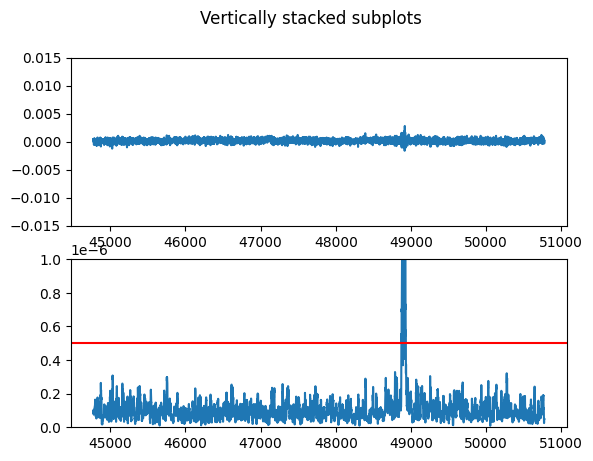

In [61]:
index = 2
print(testLabelsDf.iloc[index])
slice = data[(data["ts"]>= testLabelsDf.iloc[index]["EstimatedTime"]) & (data["ts"]<= testLabelsDf.iloc[index]["MaxTime"])]
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(slice["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(slice["vars"])
axs[1].axhline(y=5e-7, color='r')
axs[1].set_ylim(0, 1e-6)